<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_dsp_core_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test basic DSP functionalities

In [2]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [3]:
from optic.dsp.core import resample, clockSamplingInterp, quantizer, pulseShape, finddelay, delaySignal, syncDataSequences, pnorm
from optic.utils import parameters
from optic.models.tx import pamTransmitter
import matplotlib.pyplot as plt
import numpy as np


c:\Users\edson.DESKTOP-54IJM4F\anaconda3\envs\opticommpy-env\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [4]:
%load_ext autoreload
%autoreload 2

## Test resample

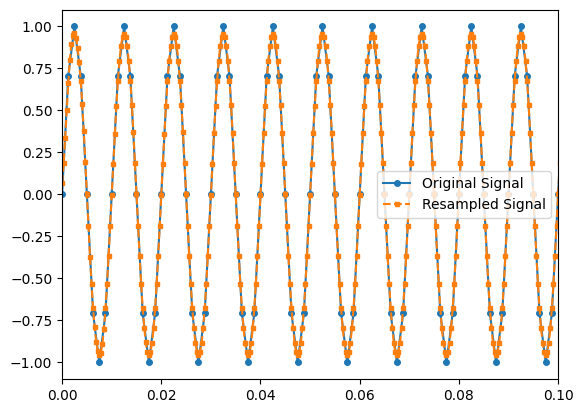

In [5]:
Fs = 800
fc = 100

t = np.arange(0,4096)*(1/Fs)
π = np.pi

sig = np.sin(2*π*fc*t)

plt.plot(t, sig,'-o',markersize=4, label='Original Signal');
plt.xlim(0, 10*1/fc)

paramRes = parameters()
paramRes.inFs = Fs    # Input sampling frequency
paramRes.outFs = 3200 # Output sampling frequency
paramRes.N = 401      # Number of taps for the anti-aliasing FIR filter

resFactor = paramRes.outFs/paramRes.inFs

t_dec = np.arange(0, int(resFactor*4096))*(1/(resFactor*Fs))
sig_dec = resample(sig, paramRes)

plt.plot(t_dec, sig_dec,'--s',markersize=3, label='Resampled Signal');
plt.xlim(0, 10*1/fc)
plt.legend()

## Test sampling clock converter

(0.0, 0.1)

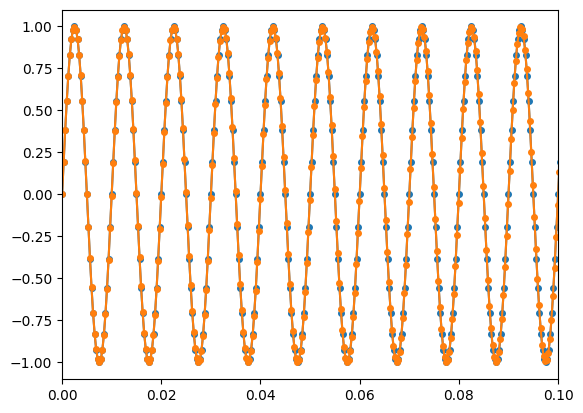

In [6]:
Fs = 3200
fc = 100

t = np.arange(0, 300000)*(1/Fs)
π = np.pi

# generate sinusoidal signal
sig = np.sin(2*π*fc*t)

plt.plot(t, sig,'-o',markersize=4);
plt.xlim(min(t), max(t))

# intermpolate signal to a given clock sampling frequency and jitter
Fs_in = Fs
Fs_out = 1.001*Fs
AAF = False
jitter_rms = 1e-9

t_dec = clockSamplingInterp(t.reshape(-1,1), Fs_in, Fs_out, jitter_rms)
sig_dec = clockSamplingInterp(sig.reshape(-1,1), Fs_in, Fs_out, jitter_rms)
plt.plot(t_dec, sig_dec,'-o',markersize=4);
plt.xlim(0, 10*1/fc)

## Test signal quantizer

(0.0, 0.1)

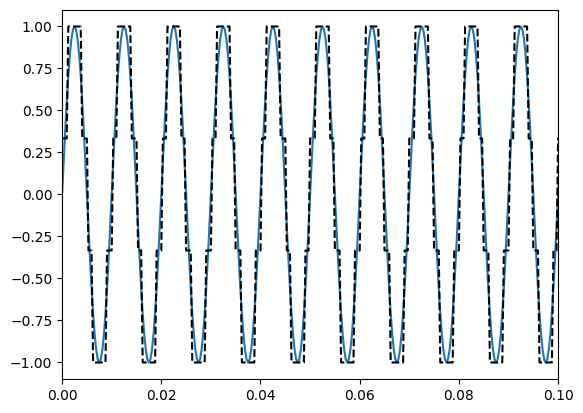

In [7]:
Fs = 3200
fc = 100

t = np.arange(0, 300000)*(1/Fs)
π = np.pi

# generate sinusoidal signal
sig = np.sin(2*π*fc*t) #+ np.sin(6*π*fc*t)/3 + np.sin(10*π*fc*t)/5

plt.plot(t, sig,'-',markersize=4);
plt.xlim(min(t), max(t))

# quantizer
nBits = 2
sig_q = quantizer(sig.reshape(-1,1), nBits)

plt.plot(t, sig_q,'--k',markersize=4);
plt.xlim(0, 10*1/fc)

(0.0, 0.1)

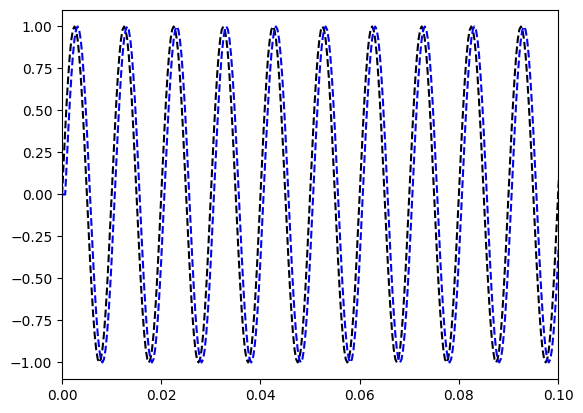

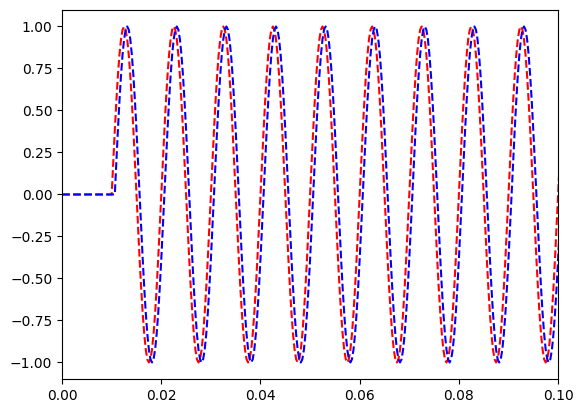

In [8]:
plt.figure(1)
plt.plot(t, sig,'--k',markersize=4);

sigd = delaySignal(sig, 2*1/Fs, Fs)

plt.plot(t, sigd, '--b',markersize=4)
plt.xlim(0, 10*1/fc)

sigd = delaySignal(sig + 1j*sigd, 32*1/Fs, Fs)

plt.figure()
plt.plot(t, sigd.real, '--r',markersize=4)
plt.plot(t, sigd.imag, '--b',markersize=4)
plt.xlim(0, 10*1/fc)

## Test pulse shaping filters

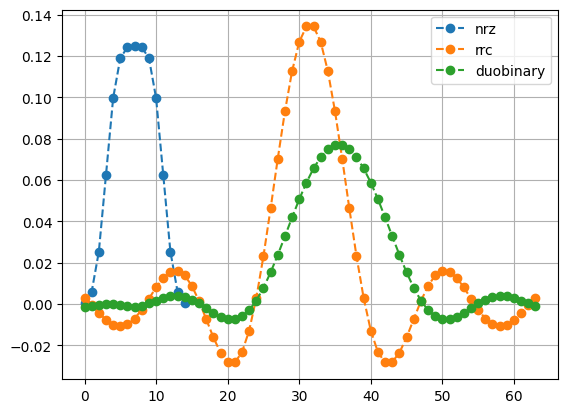

In [9]:
param = parameters()
param.SpS = 8
param.nFilterTaps = 64

for pulseName in ['nrz', 'rrc', 'duobinary']:
    param.pulseType = pulseName
    pulse = pulseShape(param)    
    plt.plot(pulse, '--o',label=pulseName)
    
plt.grid()
plt.legend()

## Test sequence syncronizer

Calculated delay after synchronization: 0 samples
Original signal length: 12000 samples
Delayed repeated signal length: 275667 samples
Synchronized signal length: 275667 samples
Synchronized symbols length: 68917 symbols


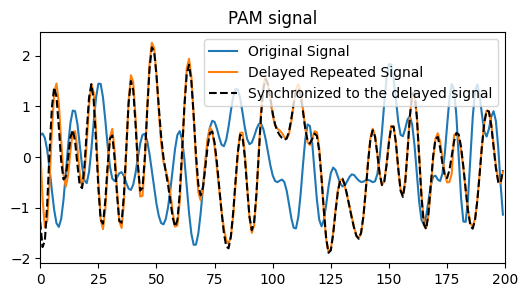

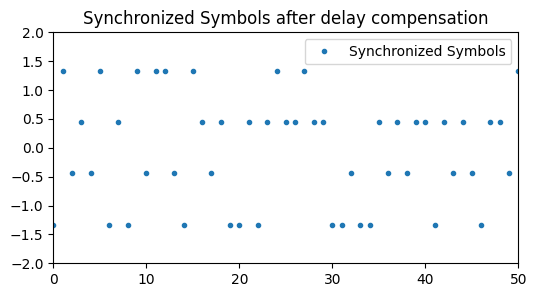

In [21]:
# generate test signal
paramTx = parameters()
paramTx.M = 4
paramTx.SpS = 4
paramTx.nBits = 6000
paramTx.pulseType = 'rrc'
paramTx.pulseRollOff = 0.001
paramTx.seed = 123
paramTx.nPolModes = 1
signal, symbols = pamTransmitter(paramTx)
signal = pnorm(signal**2 - np.mean(signal**2, axis=0))
signal = signal.reshape(-1,1)

# repeat signal
signal_rep = np.tile(signal, (23, 1))

# add delay to repeated signal
delay = 178  # samples
signal_rep = np.roll(signal_rep, delay, axis=0)

# crop length
signal_rep = signal_rep[0:-333,:]  

# synchronize sequences
param = parameters()
param.SpS = paramTx.SpS
param.pulseType = paramTx.pulseType
param.rollOff = paramTx.pulseRollOff
param.reference = 'symbols'
signal_sync, symbols_sync = syncDataSequences(signal_rep, symbols, param)

plt.figure(figsize=(6,3))
plt.plot(signal[0:50*param.SpS], '-', markersize=3, label='Original Signal')
plt.plot(signal_rep[0:50*param.SpS], '-', markersize=3, label='Delayed Repeated Signal')
plt.plot(signal_sync[0:50*param.SpS], 'k--', markersize=3, label='Synchronized to the delayed signal')
plt.xlim(0, 50*param.SpS)
plt.legend(loc = 'upper right')
plt.title('PAM signal')

plt.figure(figsize=(6,3))
plt.plot(pnorm(symbols_sync), '.', markersize=6, label='Synchronized Symbols')
plt.xlim(0, 50)
plt.ylim(-2, 2)
plt.title('Synchronized Symbols after delay compensation')
plt.legend(loc = 'upper right')

# print estimated delay
est_delay = finddelay(signal_rep, signal_sync)
print(f'Calculated delay after synchronization: {est_delay} samples')

# print lengths
print(f'Original signal length: {len(signal)} samples')
print(f'Delayed repeated signal length: {len(signal_rep)} samples')
print(f'Synchronized signal length: {len(signal_sync)} samples')
print(f'Synchronized symbols length: {len(symbols_sync)} symbols')
